# Brain tumor detection using a CNN - Training

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, LeakyReLU, BatchNormalization, Dropout, Dense, InputLayer, Flatten
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

Run the next cell only if you are working on **Google Collab**

In [3]:
import urllib
import zipfile

# Download and unzip the dataset
if not os.path.isfile('Brain Tumor Data Set.zip'):
  urllib.request.urlretrieve("https://github.com/TomMenga/brain-tumor-AI-CNN/blob/main/Brain%20Tumor%20Data%20Set.zip?raw=true", "Brain Tumor Data Set.zip")

with zipfile.ZipFile("Brain Tumor Data Set.zip","r") as zip_ref:
    zip_ref.extractall(".")

os.remove('Brain Tumor Data Set.zip')

____________________
### Parameters

In [2]:
train_dataset_path = './Brain Tumor Data Set/Train'
test_dataset_path = './Brain Tumor Data Set/Test'

weights_export_path = './model_export/weights_only/brain_tumor_CNN'
model_export_path = './model_export/whole_model/'

batch_size = 32
img_height = 128
img_width = 128

seed = 42

## Let's load our data

In [6]:
# Training set
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3826 files belonging to 2 classes.
Using 3061 files for training.


In [7]:
# Validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3826 files belonging to 2 classes.
Using 765 files for validation.


In [8]:
# Test set
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dataset_path,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 941 files belonging to 2 classes.


In [9]:
# The class names derive from the folder structure
class_names = train_ds.class_names
print(class_names)

['Cancer', 'Not cancer']


### Let's check if images are loaded correctly

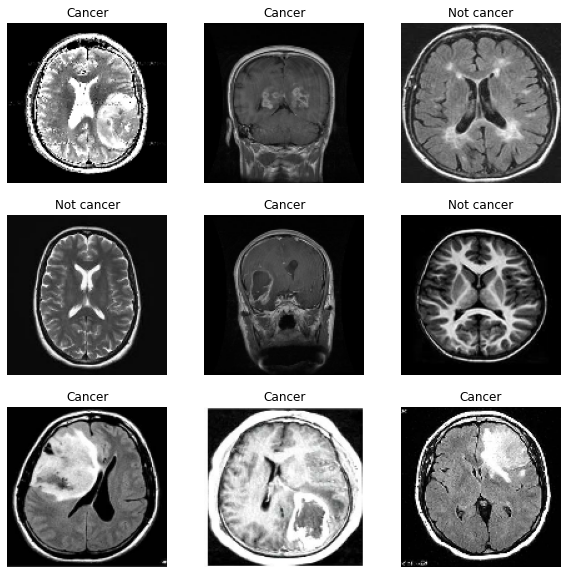

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

________________________
## Now it's time to train our model!

In [11]:
# Some optimization settings
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
# Setup the model pipeline
model = tf.keras.Sequential([
  InputLayer(input_shape=(img_height, img_width, 3)),
  Conv2D(8, 3, activation='relu'),
  MaxPool2D((2, 2)),
  Conv2D(16, 3, activation='relu'),
  MaxPool2D((2, 2)),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D((2, 2)),
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(rate=0.3),
  Dense(64, activation='relu'),
  Dropout(rate=0.3),
  Dense(1, activation="sigmoid")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 8)       224       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 8)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 32)      

In [19]:
from keras import utils, callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", 
                                        patience=5, restore_best_weights = True)

history = model.fit(
    train_ds,
    verbose=1,
    callbacks = [earlystopping],
    epochs=50,
    validation_data=val_ds)

Epoch 1/50
96/96 [==============================] - 16s 151ms/step - loss: 3.1103 - accuracy: 0.6354 - val_loss: 0.4749 - val_accuracy: 0.7752
Epoch 2/50
96/96 [==============================] - 14s 149ms/step - loss: 0.4495 - accuracy: 0.7935 - val_loss: 0.3724 - val_accuracy: 0.8366
Epoch 3/50
96/96 [==============================] - 14s 149ms/step - loss: 0.3356 - accuracy: 0.8471 - val_loss: 0.3029 - val_accuracy: 0.8967
Epoch 4/50
96/96 [==============================] - 14s 147ms/step - loss: 0.2625 - accuracy: 0.8977 - val_loss: 0.2229 - val_accuracy: 0.9333
Epoch 5/50
96/96 [==============================] - 14s 146ms/step - loss: 0.1879 - accuracy: 0.9232 - val_loss: 0.2057 - val_accuracy: 0.9176
Epoch 6/50
96/96 [==============================] - 14s 147ms/step - loss: 0.1634 - accuracy: 0.9363 - val_loss: 0.1940 - val_accuracy: 0.9320
Epoch 7/50
96/96 [==============================] - 14s 149ms/step - loss: 0.1183 - accuracy: 0.9572 - val_loss: 0.1877 - val_accuracy: 0.9386

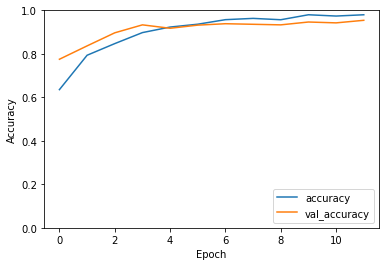

In [21]:
# Plotting accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

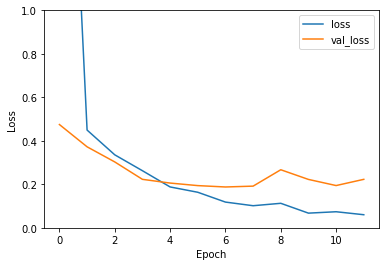

In [23]:
# Plotting loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')

## Let's evaluate its perfomance

In [24]:
eval_out = model.evaluate(test_ds,
                          verbose=1)

print('Accuracy: {} \nLoss: {}'.format(round(eval_out[1], 2), round(eval_out[0], 2)))

30/30 [==============================] - 2s 48ms/step - loss: 0.2604 - accuracy: 0.9277
Accuracy: 0.93 
Loss: 0.26


## Finally, export our model for future use

In [25]:
# You can either save just the weights
model.save_weights(weights_export_path)

# Or the whole model architecture, weights included
model.save(model_export_path)

INFO:tensorflow:Assets written to: ./model_export/whole_model/assets


INFO:tensorflow:Assets written to: ./model_export/whole_model/assets
